# АНАЛИЗ ВРЕМЕННЫХ РЯДОВ 

## Лабораторная №1 Выявить в заданном временном ряду аномальные значения по критерию Ирвина. Обнаруженные аномальные значения заменить путем интерполирования по соседним точкам. 
```
Выполнить сглаживание заданного ряда следующими методами: • среднеарифметическая по 5 точкам; 
• средневзвешенная по 5 точкам; 
• средневзвешенная по 7 точкам; 
• средне-хронологическая по 12 точкам; 
• экспоненциальное сглаживание. 
На одной диаграмме построить графики исходного ряда и все сглаженные ряды.
```

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from scipy.stats import skew, kurtosis, ttest_1samp
from scipy.optimize import curve_fit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from scipy import stats

In [20]:
file_path = 'SalesData.csv'
df = pd.read_csv(file_path)
df.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price
0,SO - 000101,In-Store,WARE-UHY1004,31/12/17,31/5/18,14/6/18,19/6/18,USD,6,15,259,12,5,0.075,"1,001.18","1,963.10"
1,SO - 000102,Online,WARE-NMK1003,31/12/17,31/5/18,22/6/18,2/7/18,USD,14,20,196,27,3,0.075,"3,348.66","3,939.60"
2,SO - 000103,Distributor,WARE-UHY1004,31/12/17,31/5/18,21/6/18,1/7/18,USD,21,16,213,16,1,0.050,781.22,"1,775.50"
3,SO - 000104,Wholesale,WARE-NMK1003,31/12/17,31/5/18,2/6/18,7/6/18,USD,28,48,107,23,8,0.075,"1,464.69","2,324.90"
4,SO - 000105,Distributor,WARE-NMK1003,10/4/18,31/5/18,16/6/18,26/6/18,USD,22,49,111,26,8,0.100,"1,476.14","1,822.40"


## Подготовка данных

In [21]:
# Преобразуем столбец дат в datetime
df["OrderDate"] = pd.to_datetime(df["OrderDate"], dayfirst=True)

# Удалим строки с пустыми датами или ценами
df = df.dropna(subset=["OrderDate", "Unit Price"])

# Преобразуем цену в числовой формат (удаление запятых и преобразование к float)
df["Unit Price"] = df["Unit Price"].str.replace(",", "").astype(float)

# Сортировка по дате
df = df.sort_values("OrderDate")
df.head()

/var/folders/d5/7h_xmkjn47nbw0jsxg5xgvyw0000gn/T/ipykernel_18191/1223094881.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["OrderDate"] = pd.to_datetime(df["OrderDate"], dayfirst=True)


,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price
0,SO - 000101,In-Store,WARE-UHY1004,31/12/17,2018-05-31,14/6/18,19/6/18,USD,6,15,259,12,5,0.075,"1,001.18",1963.1
1,SO - 000102,Online,WARE-NMK1003,31/12/17,2018-05-31,22/6/18,2/7/18,USD,14,20,196,27,3,0.075,"3,348.66",3939.6
2,SO - 000103,Distributor,WARE-UHY1004,31/12/17,2018-05-31,21/6/18,1/7/18,USD,21,16,213,16,1,0.050,781.22,1775.5
3,SO - 000104,Wholesale,WARE-NMK1003,31/12/17,2018-05-31,2/6/18,7/6/18,USD,28,48,107,23,8,0.075,"1,464.69",2324.9
4,SO - 000105,Distributor,WARE-NMK1003,10/4/18,2018-05-31,16/6/18,26/6/18,USD,22,49,111,26,8,0.100,"1,476.14",1822.4


## Создание временного ряда: дата — цена

In [22]:
ts = df[["OrderDate", "Unit Price"]].set_index("OrderDate")
ts = ts.resample("D").mean().interpolate()

ts.head(10)

,Unit Price
OrderDate,
2018-05-31,1984.037500
2018-06-01,2449.623077
2018-06-02,2583.222222
2018-06-03,3387.966667
2018-06-04,3561.050000
2018-06-05,2693.400000
2018-06-06,1974.825000
2018-06-07,2730.250000
2018-06-08,1250.028571


## Выявление аномалий по критерию Ирвина|

In [28]:
z = np.abs(np.diff(ts["Unit Price"])) / ts["Unit Price"].std()
threshold = 3
anomalies = np.where(z > threshold)[0] + 1  # +1, т.к. diff сокращает размерность

# Замена аномалий интерполяцией по соседним точкам
ts_cleaned = ts.copy()
for idx in anomalies:
    if 0 < idx < len(ts) - 1:
        ts_cleaned.iloc[idx] = (ts.iloc[idx - 1] + ts.iloc[idx + 1]) / 2

ts_cleaned.head()

,Unit Price
OrderDate,
2018-05-31,1984.037500
2018-06-01,2449.623077
2018-06-02,2583.222222
2018-06-03,3387.966667
2018-06-04,3561.050000


## Методы сглаживания 

### Скользящее среднее по 5 точкам

In [29]:
# Скользящее среднее по 5 точкам
ma_5 = ts_cleaned.rolling(window=5, center=True).mean()

# Средневзвешенное по 5 точкам (веса: 1, 2, 3, 2, 1)
weights_5 = np.array([1, 2, 3, 2, 1])
weighted_5 = ts_cleaned["Unit Price"].rolling(window=5, center=True).apply(
    lambda x: np.dot(x, weights_5) / weights_5.sum(), raw=True
)
weighted_5.head()

OrderDate
2018-05-31            NaN
2018-06-01            NaN
2018-06-02    2774.437073
2018-06-03    3066.163058
2018-06-04    3044.881173
Freq: D, Name: Unit Price, dtype: float64

### Скользящее среднее по 7 точкам

In [30]:
# Средневзвешенное по 7 точкам (веса: 1, 2, 3, 4, 3, 2, 1)
weights_7 = np.array([1, 2, 3, 4, 3, 2, 1])
weighted_7 = ts_cleaned["Unit Price"].rolling(window=7, center=True).apply(
    lambda x: np.dot(x, weights_7) / weights_7.sum(), raw=True
)
weighted_7.head()

OrderDate
2018-05-31            NaN
2018-06-01            NaN
2018-06-02            NaN
2018-06-03    2889.349499
2018-06-04    2924.016720
Freq: D, Name: Unit Price, dtype: float64

### Скользящее среднее по 12 точкам

In [32]:
# Средне-хронологическое по 12 точкам
def chronological_avg(x):
    n = len(x)
    weights = np.arange(1, n + 1)
    return np.dot(x, weights) / weights.sum()

chronological_12 = ts_cleaned["Unit Price"].rolling(window=12).apply(
    chronological_avg, raw=True
)
chronological_12.head()

OrderDate
2018-05-31   NaN
2018-06-01   NaN
2018-06-02   NaN
2018-06-03   NaN
2018-06-04   NaN
Freq: D, Name: Unit Price, dtype: float64

In [35]:
# Экспоненциальное сглаживание
exp_smooth = ts_cleaned["Unit Price"].ewm(alpha=0.3).mean()
exp_smooth.head()

OrderDate
2018-05-31    1984.037500
2018-06-01    2257.911369
2018-06-02    2406.455137
2018-06-03    2793.944884
2018-06-04    3070.568560
Freq: D, Name: Unit Price, dtype: float64

## Построение графика 

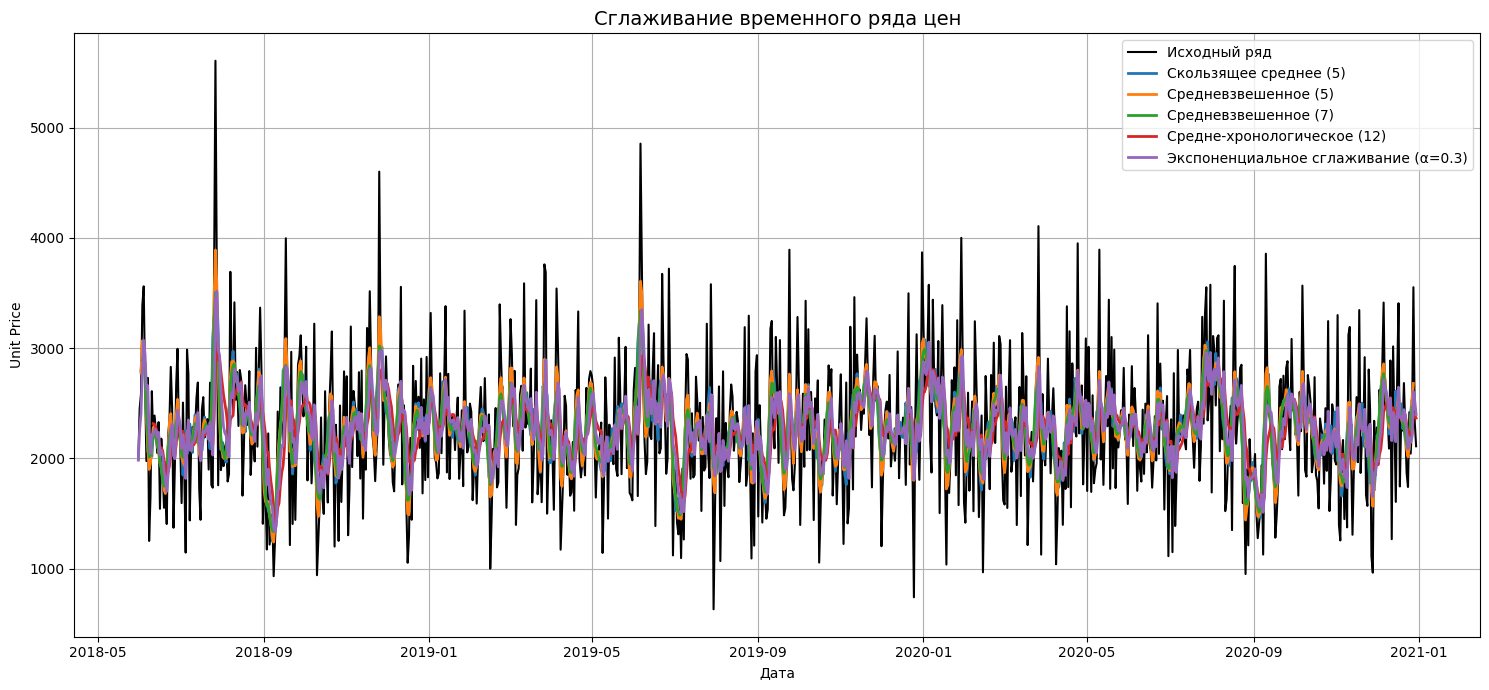

In [37]:
plt.figure(figsize=(15, 7))
plt.plot(ts_cleaned.index, ts_cleaned["Unit Price"], label="Исходный ряд", color="black", linewidth=1.5)
plt.plot(ma_5, label="Скользящее среднее (5)", linewidth=2)
plt.plot(weighted_5, label="Средневзвешенное (5)", linewidth=2)
plt.plot(weighted_7, label="Средневзвешенное (7)", linewidth=2)
plt.plot(chronological_12, label="Средне-хронологическое (12)", linewidth=2)
plt.plot(exp_smooth, label="Экспоненциальное сглаживание (α=0.3)", linewidth=2)

plt.title("Сглаживание временного ряда цен", fontsize=14)
plt.xlabel("Дата")
plt.ylabel("Unit Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

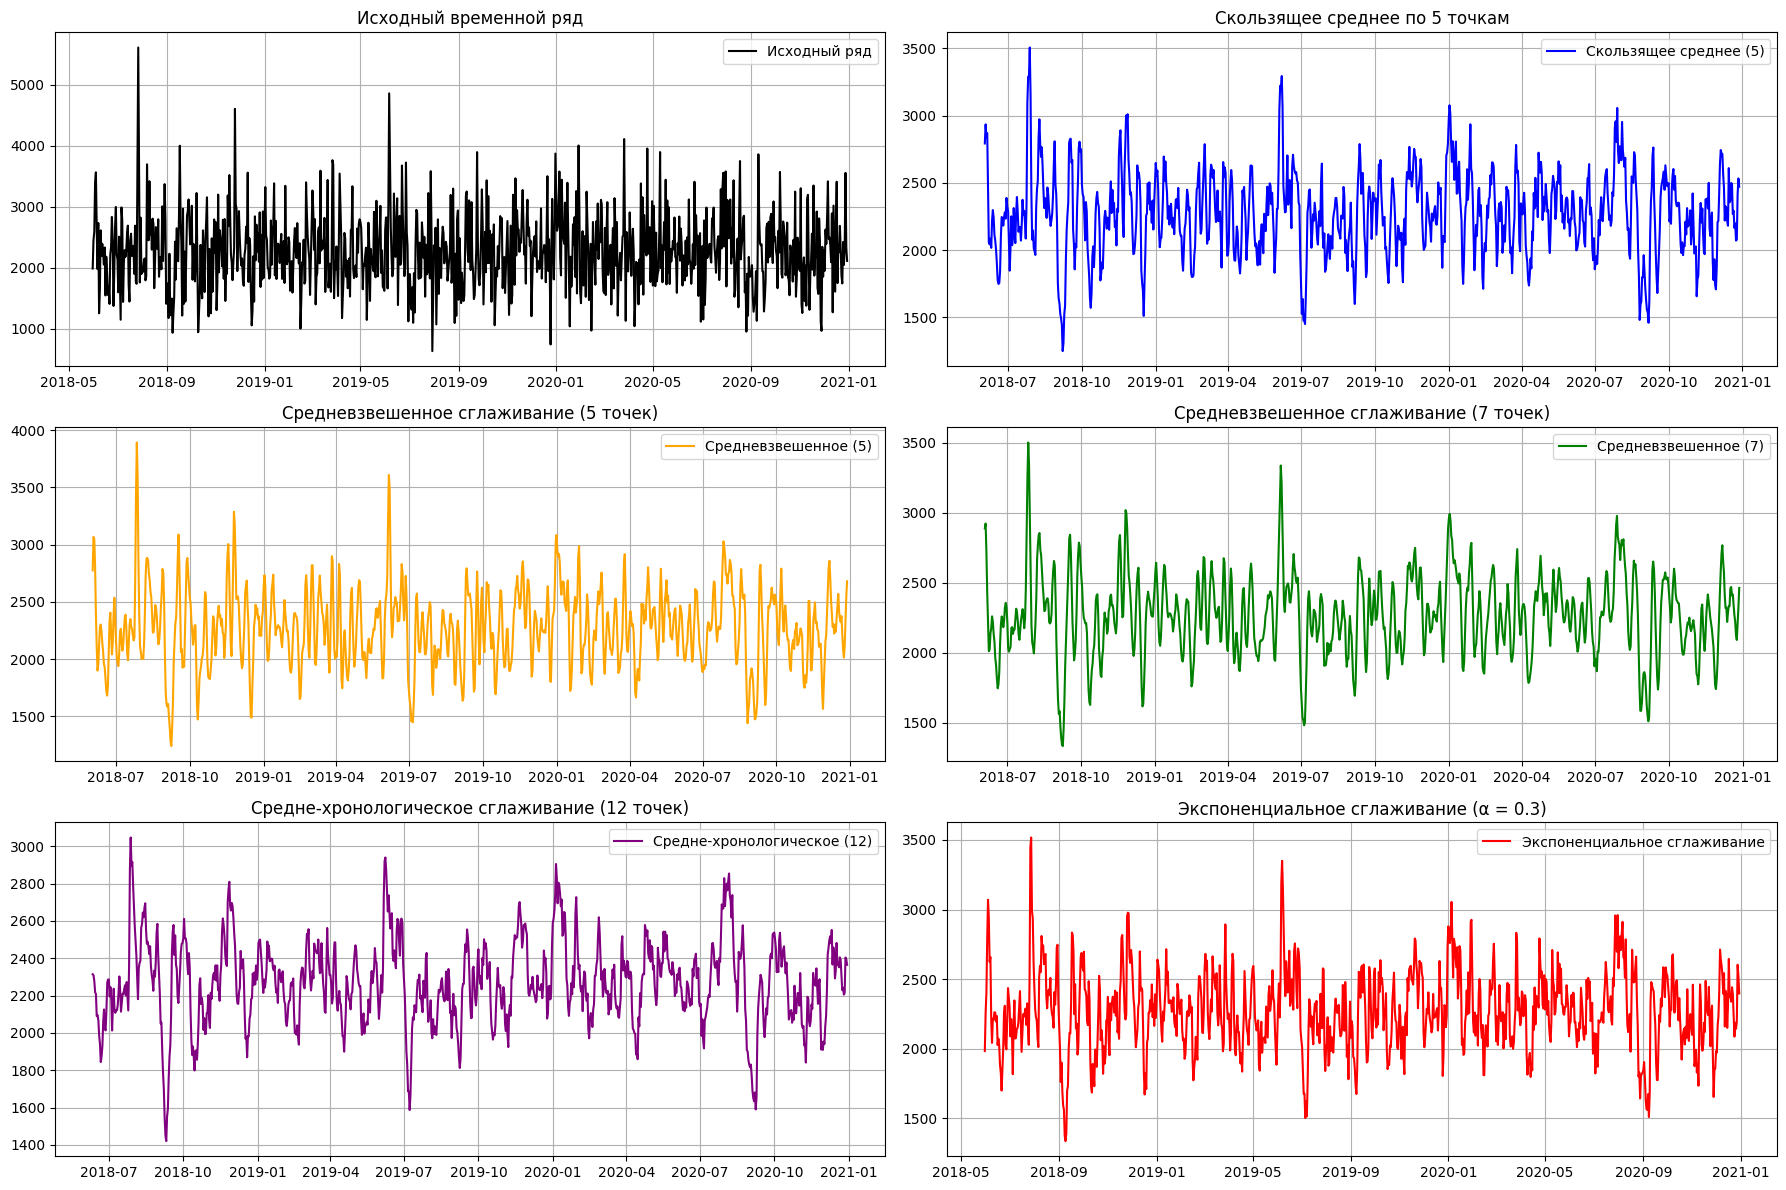

In [38]:
# Построение графиков отдельно
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
axs = axs.flatten()

axs[0].plot(ts_cleaned, label="Исходный ряд", color="black")
axs[0].set_title("Исходный временной ряд")

axs[1].plot(ma_5, label="Скользящее среднее (5)", color="blue")
axs[1].set_title("Скользящее среднее по 5 точкам")

axs[2].plot(weighted_5, label="Средневзвешенное (5)", color="orange")
axs[2].set_title("Средневзвешенное сглаживание (5 точек)")

axs[3].plot(weighted_7, label="Средневзвешенное (7)", color="green")
axs[3].set_title("Средневзвешенное сглаживание (7 точек)")

axs[4].plot(chronological_12, label="Средне-хронологическое (12)", color="purple")
axs[4].set_title("Средне-хронологическое сглаживание (12 точек)")

axs[5].plot(exp_smooth, label="Экспоненциальное сглаживание", color="red")
axs[5].set_title("Экспоненциальное сглаживание (α = 0.3)")

for ax in axs:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# Лабораторная работа 2  ОПРЕДЕЛЕНИЕ НАЛИЧИЯ ТРЕНДА


## наличие тренда методом проверки

In [40]:
y = ts_cleaned["Unit Price"].values  # или другой ваш временной ряд
n = len(y)
k = n // 2

first_half = y[:k]
second_half = y[-k:]

mean1 = np.mean(first_half)
mean2 = np.mean(second_half)
delta = mean2 - mean1
delta

24.85686636351693

```
Если delta ≈ 0 → тренда нет.
Если delta > 0 → восходящий тренд.
Если delta < 0 → нисходящий тренд.
```

In [44]:
diffs = np.diff(y)
signs = np.sign(diffs)

# Подсчёт смен знаков
U = np.sum(signs[1:] != signs[:-1])
S = np.sum(signs != 0)

E_U = (2 * S - 1) / 3
sigma_U = np.sqrt((16 * S - 29) / 90)
Z = (U - E_U) / sigma_U

abs(Z)

2.62706919157327

```
Если |Z| > 1.96 (для уровня значимости 0.05) → тренд есть.
Если |Z| <= 1.96 → тренда нет.
```

## Лабораторная работа 3 ВЫДЕЛЕНИЕ КОМПОНЕНТ ТРЕНД-СЕЗОННОГО

```
Для выполнения задания по выделению компонентов временного ряда Yt— тренда Ut-сезонной компоненты Vt и остатка εt 
аддитивная модель: Yt = Ut + Vt + εt
```

## Загрузка данных 

In [52]:
df = pd.read_csv("SalesData.csv", parse_dates=["OrderDate"])

# Преобразование и очистка Unit Price
df["Unit Price"] = df["Unit Price"].astype(str).str.replace(",", "")
df["Unit Price"] = pd.to_numeric(df["Unit Price"], errors="coerce")


df = df.sort_values("OrderDate")
ts = df.groupby(df["OrderDate"].dt.to_period("M"))["Unit Price"].mean().dropna()
ts.index = ts.index.to_timestamp()

ts.head()

/var/folders/d5/7h_xmkjn47nbw0jsxg5xgvyw0000gn/T/ipykernel_64931/3349766250.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("SalesData.csv", parse_dates=["OrderDate"])


OrderDate
2018-01-01    2330.036667
2018-02-01    2047.798113
2018-03-01    2226.757407
2018-04-01    2336.781333
2018-05-01    1797.088889
Freq: MS, Name: Unit Price, dtype: float64

## Построение трендов

In [53]:
prelim_trend = ts.rolling(window=5, center=True).mean()
first_trend = prelim_trend.rolling(window=5, center=True).mean()
first_trend.head()

OrderDate
2018-01-01            NaN
2018-02-01            NaN
2018-03-01            NaN
2018-04-01            NaN
2018-05-01    2167.810105
Freq: MS, Name: Unit Price, dtype: float64

## линейная регрессия

In [54]:
X = np.arange(len(ts)).reshape(-1, 1)
y = ts.values
linreg = LinearRegression().fit(X, y)
second_trend = linreg.predict(X)

## Сезонная компонента

In [55]:
detrended = ts - second_trend
months = ts.index.month
seasonal_df = pd.DataFrame({"Month": months, "Detrended": detrended})
seasonal_means = seasonal_df.groupby("Month")["Detrended"].mean()
seasonal_means

Month
1      85.077939
2     -53.833517
3     -11.868359
4     -34.452609
5    -118.696084
6      -7.678897
7      61.704081
8     -48.950519
9      43.847421
10    -73.164032
11    153.257478
12      4.757099
Name: Detrended, dtype: float64

In [56]:
# Первая сезонная волна
seasonal_wave_1 = ts.index.to_series().dt.month.map(seasonal_means).values

# Вторая волна — сглаживание первой
seasonal_wave_2 = pd.Series(seasonal_wave_1).rolling(window=3, center=True, min_periods=1).mean().values

## Остатки

In [57]:
residuals = ts.values - second_trend - seasonal_wave_2

## Построение графиков 

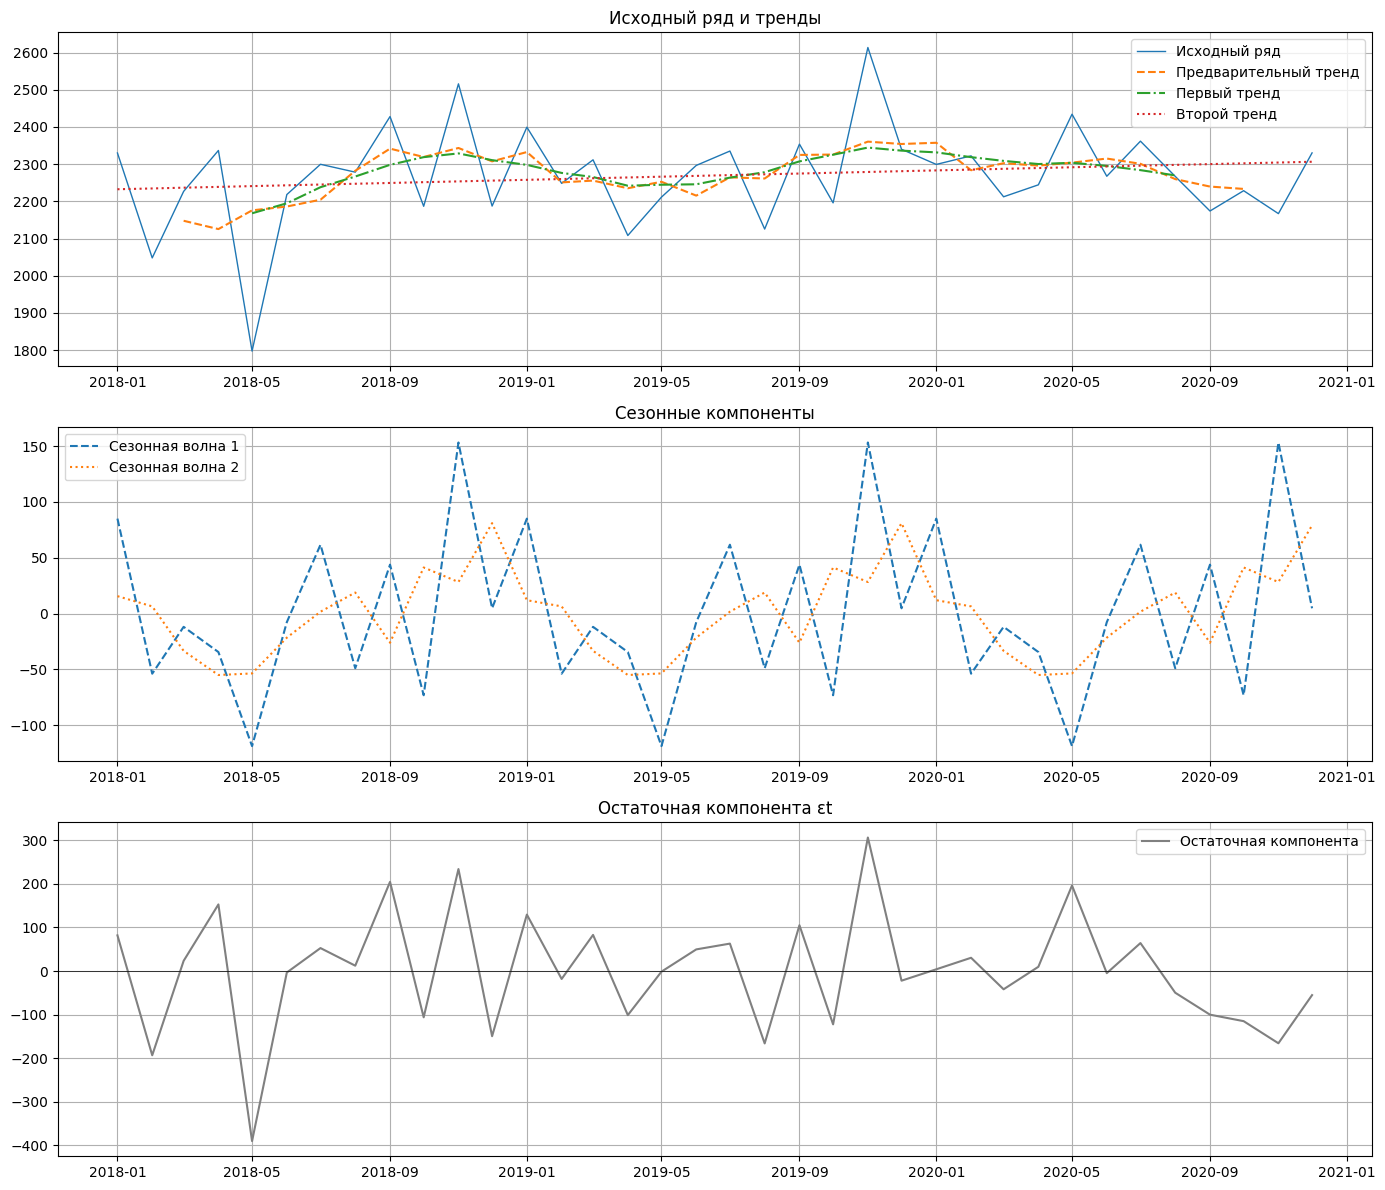

In [60]:
plt.figure(figsize=(14, 12))

# 1. Исходный ряд и тренды
plt.subplot(3, 1, 1)
plt.plot(ts.index, ts.values, label="Исходный ряд", linewidth=1)
plt.plot(ts.index, prelim_trend, label="Предварительный тренд", linestyle="--")
plt.plot(ts.index, first_trend, label="Первый тренд", linestyle="-.")
plt.plot(ts.index, second_trend, label="Второй тренд", linestyle=":")
plt.title("Исходный ряд и тренды")
plt.grid(True)
plt.legend()

# 2. Сезонные волны
plt.subplot(3, 1, 2)
plt.plot(ts.index, seasonal_wave_1, label="Сезонная волна 1", linestyle="--")
plt.plot(ts.index, seasonal_wave_2, label="Сезонная волна 2", linestyle=":")
plt.title("Сезонные компоненты")
plt.grid(True)
plt.legend()

# 3. Остаточная компонента
plt.subplot(3, 1, 3)
plt.plot(ts.index, residuals, label="Остаточная компонентa", color='gray')
plt.axhline(0, color="black", linewidth=0.5)
plt.title("Остаточная компонента εt")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Лабораторная работа 4 ВЫБОР КРИВОЙ РОСТА И ОПРЕДЕЛЕНИЕ ЕЕ ПАРАМЕТРОВ


##  Сглаживание по 3 точкам

In [67]:
# временной ряд:
ts = df.groupby(df["OrderDate"].dt.to_period("M"))["Unit Price"].mean()

#в DataFrame
ts_df = ts.to_timestamp().reset_index()
ts_df.columns = ['Date', 'Y']
ts_df['t'] = np.arange(len(ts_df))

# Сглаживание по 3 точкам (скользящее среднее)
ts_df['Y_smoothed'] = ts_df['Y'].rolling(window=3, center=True).mean()
ts_df.head()

,Date,Y,t,Y_smoothed
0,2018-01-01,2330.036667,0,NaN
1,2018-02-01,2047.798113,1,2201.530729
2,2018-03-01,2226.757407,2,2203.778951
3,2018-04-01,2336.781333,3,2120.209210
4,2018-05-01,1797.088889,4,2117.361047


## . Вычисление производных и таблицы 4

In [68]:
# Первая разность (приближенная производная)
ts_df['Delta_Y'] = ts_df['Y_smoothed'].diff()
# Вторая разность
ts_df['Delta2_Y'] = ts_df['Delta_Y'].diff()
# Условная скорость
ts_df['V'] = ts_df['Delta_Y']
ts_df.head()

,Date,Y,t,Y_smoothed,Delta_Y,Delta2_Y,V
0,2018-01-01,2330.036667,0,NaN,NaN,NaN,NaN
1,2018-02-01,2047.798113,1,2201.530729,NaN,NaN,NaN
2,2018-03-01,2226.757407,2,2203.778951,2.248222,NaN,2.248222
3,2018-04-01,2336.781333,3,2120.209210,-83.569741,-85.817964,-83.569741
4,2018-05-01,1797.088889,4,2117.361047,-2.848163,80.721579,-2.848163


### Полином 1-го порядка:

In [19]:
X = ts_df[['t']]
y = ts_df['Y']
linear_model = LinearRegression()
linear_model.fit(X, y)
ts_df['Linear'] = linear_model.predict(X)

### Экспоненциальная кривая роста:

In [20]:
ts_filtered = ts_df[ts_df['Y'] > 0].copy()

def exp_func(t, a, b):
    return a * np.exp(b * t)

params, _ = curve_fit(exp_func, ts_filtered['t'], ts_filtered['Y'])
ts_filtered['ExpGrowth'] = exp_func(ts_filtered['t'], *params)

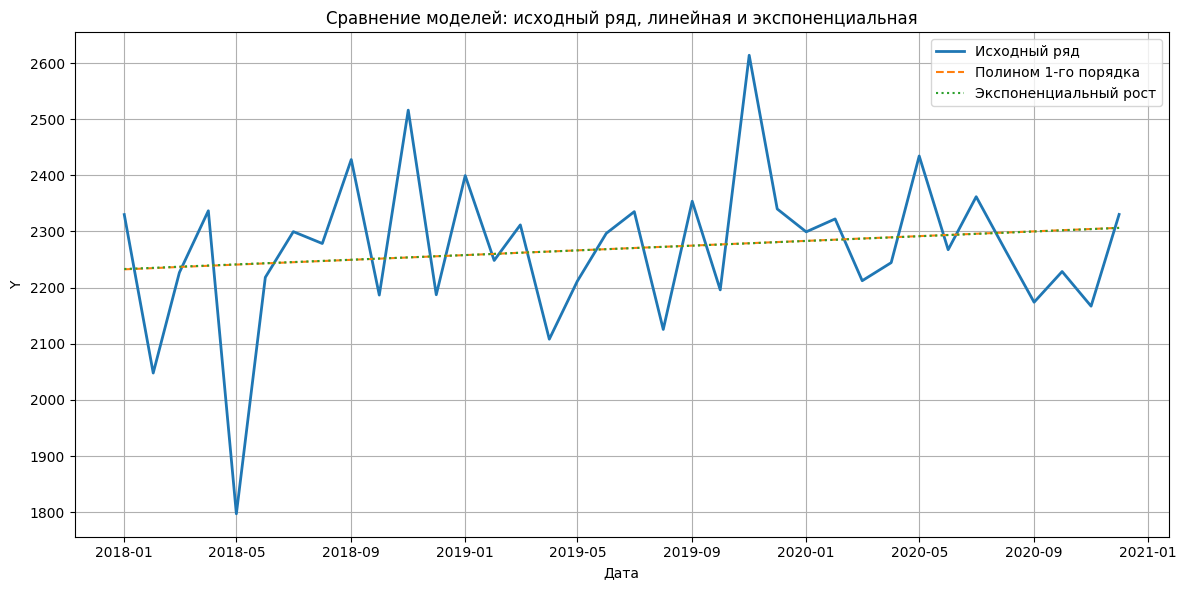

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(ts_df['Date'], ts_df['Y'], label='Исходный ряд', linewidth=2)
plt.plot(ts_df['Date'], ts_df['Linear'], label='Полином 1-го порядка', linestyle='--')
plt.plot(ts_filtered['Date'], ts_filtered['ExpGrowth'], label='Экспоненциальный рост', linestyle=':')
plt.title('Сравнение моделей: исходный ряд, линейная и экспоненциальная')
plt.xlabel('Дата')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Лабораторная работа 5 ОЦЕНКА АДЕКВАТНОСТИ ТРЕНДОВОЙ МОДЕЛИ

In [22]:
ts_df['residuals'] = residuals
ts_df.head()

,Date,Y,t,Y_smoothed,Delta_Y,Delta2_Y,V,Linear,residuals
0,2018-01-01,2330.036667,0,NaN,NaN,NaN,NaN,2232.497338,81.917118
1,2018-02-01,2047.798113,1,2201.530729,NaN,NaN,NaN,2234.610847,-193.271421
2,2018-03-01,2226.757407,2,2203.778951,2.248222,NaN,2.248222,2236.724355,23.417881
3,2018-04-01,2336.781333,3,2120.209210,-83.569741,-85.817964,-83.569741,2238.837863,152.949154
4,2018-05-01,1797.088889,4,2117.361047,-2.848163,80.721579,-2.848163,2240.951372,-390.253286


## Критерий пиков (проверка случайности)

In [23]:
def peak_test(residuals):
    peaks = 0
    for i in range(1, len(residuals) - 1):
        if (residuals[i] > residuals[i-1]) and (residuals[i] > residuals[i+1]):
            peaks += 1
        elif (residuals[i] < residuals[i-1]) and (residuals[i] < residuals[i+1]):
            peaks += 1
    return peaks

n = len(residuals)
peaks = peak_test(residuals)
expected_peaks = (2 * (n - 2)) / 3
std_peaks = np.sqrt((16 * n - 29) / 90)
z_peak = (peaks - expected_peaks) / std_peaks

print(f"Число пиков: {peaks}")
print(f"Z-пик = {z_peak:.3f}")

Число пиков: 25
Z-пик = 0.946


## Критерий серий (проверка случайности)

In [24]:
def run_test(residuals):
    signs = np.sign(residuals - np.mean(residuals))
    series = 1
    for i in range(1, len(signs)):
        if signs[i] != signs[i-1] and signs[i] != 0 and signs[i-1] != 0:
            series += 1
    return series

S = run_test(residuals)
n_plus = np.sum(residuals > 0)
n_minus = np.sum(residuals < 0)
M = (2 * n_plus * n_minus) / (n_plus + n_minus) + 1
D = (2 * n_plus * n_minus * (2 * n_plus * n_minus - n_plus - n_minus)) / \
    (((n_plus + n_minus) ** 2) * (n_plus + n_minus - 1))
z_run = (S - M) / np.sqrt(D)

print(f"Число серий: {S}")
print(f"Z-серий = {z_run:.3f}")

Число серий: 24
Z-серий = 1.691


## Проверка нормальности распределения:

### Показатели асимметрии и эксцесса:

In [ ]:
sk = skew(residuals)
kt = kurtosis(residuals)  
print(f"Асимметрия: {sk:.3f}")
print(f"Эксцесс: {kt:.3f}")

Асимметрия: -0.225
Эксцесс: 0.777


### RS-критерий (Rescaled Range)

In [26]:
def rs_statistic(series):
    mean = np.mean(series)
    dev = series - mean
    cum_dev = np.cumsum(dev)
    R = np.max(cum_dev) - np.min(cum_dev)
    S = np.std(series, ddof=1)
    return R / S

rs = rs_statistic(residuals)
print(f"RS-статистика: {rs:.3f}")

RS-статистика: 5.999


## Критерий Стьюдента: H0​:μ=0

In [27]:
t_stat, p_value = ttest_1samp(residuals, 0)

print(f"t-Стьюдент: {t_stat:.3f}, p-value: {p_value:.4f}")

t-Стьюдент: -0.002, p-value: 0.9984


Если p > 0.05 — математическое ожидание не отличается от 0.

## Критерий Дарбина-Уотсона (проверка автокорреляции):


In [28]:
dw_stat = durbin_watson(residuals)
print(f"Статистика Дарбина-Уотсона: {dw_stat:.3f}")

Статистика Дарбина-Уотсона: 2.689


```
DW ≈ 2 — нет автокорреляции. Остатки независимы (нормально) 
DW < 1.5 — положительная автокорреляция. Присутствует положительная автокорреляция (остатки "повторяют" друг друга) 
DW > 2.5 — отрицательная автокорреляция. Присутствует отрицательная автокорреляция (остатки "чередуются" по знаку) 
```

1. Критерий пиков
```
Число пиков: 25, Z-пик = 0.946
Интерпретация: Z-значение меньше 1.96 → гипотеза о случайности не отвергается.
Остатки не содержат избыточного количества экстремальных значений — случайны.
```
2. Критерий серий
```
Число серий: 24, Z-серий = 1.691
 Интерпретация: Z < 1.96 → гипотеза о случайности сохраняется.
 Знаки остатков чередуются достаточно случайно — нет структурных зависимостей.
```
3. Асимметрия = -0.225
```
 Интерпретация: Значение близко к 0 → распределение остатков симметрично.
 Нет смещения влево или вправо — соответствие нормальному распределению.
```

4. Эксцесс = 0.777
```
 Эксцесс показывает "островершинность" распределения.
 Теоретическое значение для нормального распределения: 0
 0.777 — допустимое значение, остатки близки к нормальному распределению, немного более "плоские".
```

5. RS-критерий = 5.999
```
Интерпретация зависит от количества наблюдений. В данном контексте значение не критично высокое.
Показатель не указывает на существенные отклонения от случайности.
```

6. t-критерий Стьюдента
```
t = -0.002, p-value = 0.9984
Гипотеза: мат. ожидание остатков = 0
Очень высокая p-value → гипотеза не отвергается → среднее значение остатков ≈ 0
```

 7. Дарбин-Уотсон = 2.689
```
 Значение больше 2, ближе к 3 → слабая отрицательная автокорреляция.
 Хотя это не идеальное значение, оно всё ещё в допустимых границах. Отрицательная автокорреляция может говорить о лёгкой переадаптации, но не критична, если остальные критерии в норме.
```


```
Трендовая модель адекватна. Она хорошо описывает основную структуру временного ряда. Остатки случайны, несмещённы, и в целом соответствуют требованиям к хорошей модели.
текущая модель удовлетворительные результаты.
```

# Лабораторная работа 6 ПРОГНОЗИРОВАНИЕ НА ОСНОВЕ ТРЕНДОВОЙ МОДЕЛИ

In [29]:
ts_df.head()

,Date,Y,t,Y_smoothed,Delta_Y,Delta2_Y,V,Linear,residuals
0,2018-01-01,2330.036667,0,NaN,NaN,NaN,NaN,2232.497338,81.917118
1,2018-02-01,2047.798113,1,2201.530729,NaN,NaN,NaN,2234.610847,-193.271421
2,2018-03-01,2226.757407,2,2203.778951,2.248222,NaN,2.248222,2236.724355,23.417881
3,2018-04-01,2336.781333,3,2120.209210,-83.569741,-85.817964,-83.569741,2238.837863,152.949154
4,2018-05-01,1797.088889,4,2117.361047,-2.848163,80.721579,-2.848163,2240.951372,-390.253286


In [30]:
# Линейная модель
X_linear = sm.add_constant(ts_df["t"])
model_linear = sm.OLS(ts_df["Y"], X_linear).fit()

# Квадратичная модель
ts_df["t2"] = ts_df["t"]**2
X_quad = sm.add_constant(ts_df[["t", "t2"]])
model_quad = sm.OLS(ts_df["Y"], X_quad).fit()

# Кубическая модель
ts_df["t3"] = ts_df["t"]**3
X_cubic = sm.add_constant(ts_df[["t", "t2", "t3"]])
model_cubic = sm.OLS(ts_df["Y"], X_cubic).fit()

ts_df.head()

,Date,Y,t,Y_smoothed,Delta_Y,Delta2_Y,V,Linear,residuals,t2,t3
0,2018-01-01,2330.036667,0,NaN,NaN,NaN,NaN,2232.497338,81.917118,0,0
1,2018-02-01,2047.798113,1,2201.530729,NaN,NaN,NaN,2234.610847,-193.271421,1,1
2,2018-03-01,2226.757407,2,2203.778951,2.248222,NaN,2.248222,2236.724355,23.417881,4,8
3,2018-04-01,2336.781333,3,2120.209210,-83.569741,-85.817964,-83.569741,2238.837863,152.949154,9,27
4,2018-05-01,1797.088889,4,2117.361047,-2.848163,80.721579,-2.848163,2240.951372,-390.253286,16,64


In [31]:
# Линейный прогноз
X_future_linear = sm.add_constant(ts_df["t"])
forecast_linear = model_linear.get_prediction(X_future_linear).summary_frame(alpha=0.05)

# Квадратичный прогноз
X_future_quad = sm.add_constant(ts_df[["t", "t2"]])
forecast_quad = model_quad.get_prediction(X_future_quad).summary_frame(alpha=0.05)

# Кубический прогноз
X_future_cubic = sm.add_constant(ts_df[["t", "t2", "t3"]])
forecast_cubic = model_cubic.get_prediction(X_future_cubic).summary_frame(alpha=0.05)


In [32]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9121
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.346
Time:                        22:54:15   Log-Likelihood:                -227.42
No. Observations:                  36   AIC:                             458.8
Df Residuals:                      34   BIC:                             462.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2232.4973     45.038     49.569      0.000    2140.970    2324.025
t              2.1135      2.213      0.955      0.346      -2.384       6.611
==============================================================================
Omnibus:                        7.259   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                8.857
Skew:                          -0.430   Prob(JB):                       0.0119
Kurtosis:                       5.273   Cond. No.                         39.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
model_cubic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.9065
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.449
Time:                        22:54:15   Log-Likelihood:                -226.43
No. Observations:                  36   AIC:                             460.9
Df Residuals:                      32   BIC:                             467.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2179.9260     83.384     26.143      0.000    2010.077    2349.775
t              9.3609     20.926      0.447      0.658     -33.264      51.986
t2            -0.0364      1.401     -0.026      0.979      -2.890       2.817
t3            -0.0054      0.026     -0.204      0.840      -0.059       0.048
==============================================================================
Omnibus:                        5.717   Durbin-Watson:                   2.521
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.441
Skew:                          -0.416   Prob(JB):                       0.0658
Kurtosis:                       4.713   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
model_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.379
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.266
Time:                        22:54:16   Log-Likelihood:                -226.45
No. Observations:                  36   AIC:                             458.9
Df Residuals:                      33   BIC:                             463.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2169.3875     64.530     33.618      0.000    2038.100    2300.675
t             13.2505      8.532      1.553      0.130      -4.107      30.608
t2            -0.3182      0.236     -1.351      0.186      -0.798       0.161
==============================================================================
Omnibus:                        5.780   Durbin-Watson:                   2.519
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.569
Skew:                          -0.415   Prob(JB):                       0.0618
Kurtosis:                       4.739   Cond. No.                     1.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

```
R² = 0.199 → модель объясняет ~19.9% дисперсии итогового балла (Exam_Score).
F-statistic = 817.8, Prob(F) = 4.68e-318 → модель в целом значима (не все коэффициенты)
Не влияет статистически значимо на экзаменационную оценку при учёте количества часов учёбы.
```

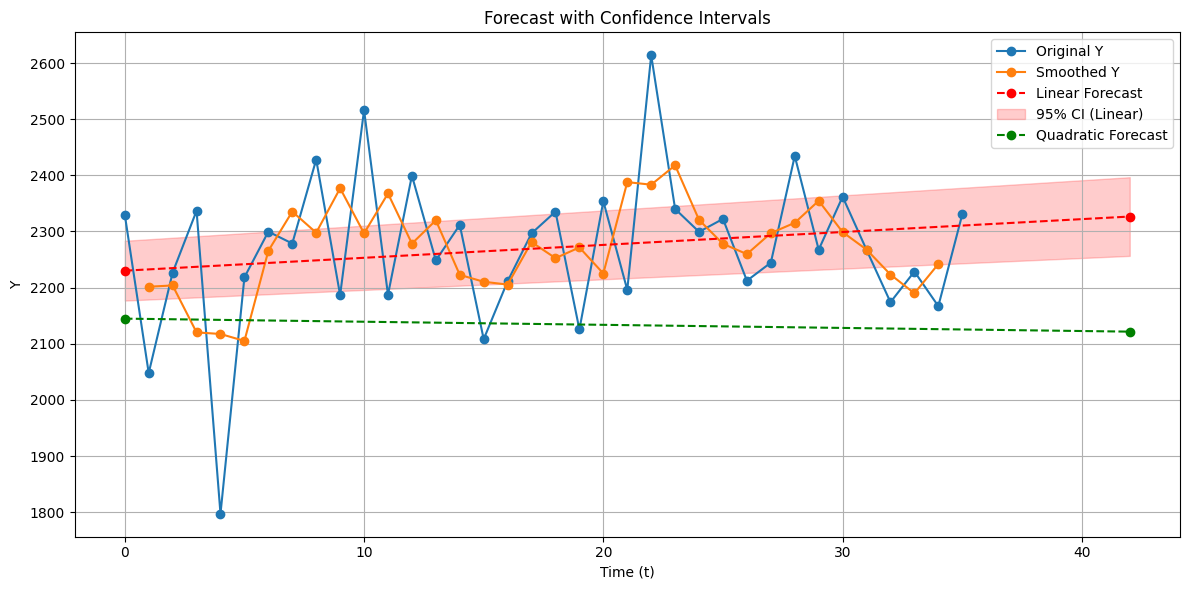

In [79]:
# Фильтрация NaN и получение подмножества для моделирования
clean_df = ts_df.dropna(subset=["Y_smoothed"])
X = clean_df["t"]
Y = clean_df["Y_smoothed"]

# Линейная модель
linear_model = np.polyfit(X, Y, 1)
linear_func = np.poly1d(linear_model)

# Нелинейная модель (квадратичная)
quad_model = np.polyfit(X, Y, 2)
quad_func = np.poly1d(quad_model)

# Прогнозы на 3 и 7 шагов вперёд
forecast_steps = [0, 42]
forecast_linear = [linear_func(t) for t in forecast_steps]
forecast_quad = [quad_func(t) for t in forecast_steps]

# Вычисление доверительных интервалов для линейной модели
n = len(X)
mean_x = np.mean(X)
t_value = stats.t.ppf(0.975, df=n-2)
s_err = np.sqrt(np.sum((Y - linear_func(X))**2) / (n - 2))

# Стандартная ошибка прогноза
def prediction_interval(x, model, s_err, mean_x, t_value, X):
    conf = t_value * s_err * np.sqrt(1/n + ((x - mean_x)**2 / np.sum((X - mean_x)**2)))
    return conf

conf_intervals_linear = [prediction_interval(t, linear_func, s_err, mean_x, t_value, X) for t in forecast_steps]
lower_linear = [f - c for f, c in zip(forecast_linear, conf_intervals_linear)]
upper_linear = [f + c for f, c in zip(forecast_linear, conf_intervals_linear)]

# График прогнозов
plt.figure(figsize=(12, 6))
plt.plot(ts_df["t"], ts_df["Y"], label="Original Y", marker="o")
plt.plot(clean_df["t"], Y, label="Smoothed Y", marker="o")
plt.plot(forecast_steps, forecast_linear, 'ro--', label="Linear Forecast")
plt.fill_between(forecast_steps, lower_linear, upper_linear, color='r', alpha=0.2, label="95% CI (Linear)")

# Прогноз квадратичной модели (точечный)
plt.plot(forecast_steps, forecast_quad, 'go--', label="Quadratic Forecast")

plt.title("Forecast with Confidence Intervals")
plt.xlabel("Time (t)")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
clean_df

,Date,Y,t,Y_smoothed,Delta_Y,Delta2_Y,V
1,2018-02-01,2047.798113,1,2201.530729,NaN,NaN,NaN
2,2018-03-01,2226.757407,2,2203.778951,2.248222,NaN,2.248222
3,2018-04-01,2336.781333,3,2120.209210,-83.569741,-85.817964,-83.569741
4,2018-05-01,1797.088889,4,2117.361047,-2.848163,80.721579,-2.848163
5,2018-06-01,2218.212919,5,2104.977163,-12.383884,-9.535721,-12.383884
6,2018-07-01,2299.629680,6,2265.446660,160.469497,172.853381,160.469497
7,2018-08-01,2278.497380,7,2335.389771,69.943112,-90.526385,69.943112
8,2018-09-01,2428.042254,8,2297.730565,-37.659206,-107.602318,-37.659206
9,2018-10-01,2186.652062,9,2376.915625,79.185059,116.844266,79.185059
10,2018-11-01,2516.052558,10,2296.653136,-80.262488,-159.447547,-80.262488
